## Feature exploration  

The purpose of this notebook is to identify features. I'll go about it by specifying a set of hypotheses and then going through the one by one.

### Hypotheses about useful features 

**Weekday**  
There could well be differences in performance and the quality of opposition by weekday.  

**Hour of the day**  
Perhaps my play is sharper in the morning than in the evening or the other way around.

**Time control category**  
Most of the games in the training data was played with 3 minuter per player. But some are 5 minute games or games with extra time added per move.

**Color**  
It's an advantage to play white and play the first move, so this one's almost certainly will be linked to the result.

**Gripklo's rating**  
This feature is likely only important as a proxy for opponent rating, but maybe there's something else there as well. 

**Opponent's rating**  
The strength of the opponent should be a good predictor.

**The rating difference**  
Perhaps the relative ratings of the players are more telling than each player's absolute rating.  

**The last game's result**  
Perhaps a performance is influenced by the state of mind from the last game, or maybe the previous game is an indicator of form.

**The last 5 game's result**  
Try catching winning and losing streaks with an average points taken over last 5 games.

**The number of games played in the last x hours**  
Playing many games in short time could affect the quality.

**Rematch**  
If the last game was played against the same opponent that could influence the dynamic

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

sns.set()
default_color = 'steelblue'

weekday_mapper = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'}


def chi2(df, X, y):
    """ Use scipy.stats.chi2_contingency to calculate and print a p-value 
    for a categorical frequency table""" 
    obs = np.array(df.groupby([y, X]).size()
                   .reset_index()
                   .pivot_table(index=y, columns=X)
                   .replace(np.nan, 0))
    chi2, p, dof, ex = chi2_contingency(obs)
    print(f"Chi2 test p value for freqs {X} and {y}: {np.round(p, 3)}")

### Load data

In [2]:
# Read training data into a pandas DataFrame : df
df = pd.read_csv('/home/jovyan/work/data/train_data.csv')

# Create additional columns for convenience
df['start_ts'] = pd.to_datetime(df['start_date_local'].astype('str') + " " +  df['start_time_local'].astype('str'))
df['end_ts'] = pd.to_datetime(df['end_date_local'].astype('str') + " " +  df['end_time_local'].astype('str'))

# Sort chronologically to make sequential features easier to compute
df = df.sort_values('end_ts', ascending=True)

# Load ECO codes reference table
eco = pd.read_csv('/home/jovyan/work/data/eco_codes.csv', delimiter=';')

### Add and drop columns

In [3]:
# Number of games played in x hours
def num_games_past_hours(df, num_hours):
    num_games = (
        df.rolling(str(num_hours)+'h', min_periods=1, closed='both', on='end_ts')
        ['game_id'].count().sub(1))  # Don't count self
    return num_games

def avg_points_prev_games(df, num_games):
    avg_points = (
        df.rolling(num_games, min_periods=1, closed='both')
        ['won_points'].sum()
        .sub(df['won_points'])  # Don't inlude the record's result
        .div(num_games)
    )
    return avg_points

# Time columns 
df['month'] = df['start_ts'].dt.month
df['weekday'] = df['start_ts'].dt.weekday
df['hour'] = df['start_ts'].dt.hour

# Extra seconds
df['is_3min'] = df['time_control'].str.startswith('180').astype('int')

# ECO code category
df['eco_cat'] = df.merge(eco)['eco'].str[:1]

# Rating difference, positive values meaning Hikaru's rating was higher
df['rating_diff'] = df['rating'].sub(df['opp_rating'])

# The points won in the previous game
df['prev_points'] = df['won_points'].shift(1)

# The points won in the previous game
df['prev_termination'] = df['termination'].shift(1)

# The points won in the previous game
df['prev_seconds'] = (df['end_ts'] - df['start_ts']).dt.total_seconds().shift(1)

df['avg_points_last_3'] = avg_points_prev_games(df, num_games=3)
df['avg_points_last_5'] = avg_points_prev_games(df, num_games=5)
df['avg_points_last_10'] = avg_points_prev_games(df, num_games=10)

df['num_games_1h'] = num_games_past_hours(df, num_hours=1)
df['num_games_5h'] = num_games_past_hours(df, num_hours=5)
df['num_games_24h'] = num_games_past_hours(df, num_hours=24)

# Rematch
df['is_rematch'] = (df['opp_name'].shift(1) == df['opp_name']).astype('int')


# Lost last game by resignation
df['did_resign_last'] = ((df['termination'].shift(1) == 'resignation') &
                            (df['is_loss'].shift(1) == 1)).astype('int')

# Lost last game by time
df['lost_last_by_time'] = ((df['termination'].shift(1) == 'time') &
                            (df['is_loss'].shift(1) == 1)).astype('int')

# Filter columns
df = df[[
    'end_ts',
    'month',
    'weekday',
    'hour',
    'is_white',
    'rating',
    'opp_rating',
    'rating_diff',
    'is_3min',
    'eco_cat',
    'won_points',
    'prev_termination',
    'prev_points',
    'prev_seconds',
    'avg_points_last_3',
    'avg_points_last_5',
    'avg_points_last_10',
    'num_games_1h',
    'num_games_5h',
    'num_games_24h',
    'is_rematch',
    'did_resign_last',
    'lost_last_by_time',
    'is_loss']].copy()

In [4]:
df.head(3)

,end_ts,month,weekday,hour,is_white,rating,opp_rating,rating_diff,is_3min,eco_cat,...,avg_points_last_3,avg_points_last_5,avg_points_last_10,num_games_1h,num_games_5h,num_games_24h,is_rematch,did_resign_last,lost_last_by_time,is_loss
1567,2020-12-12 10:18:58,12,5,10,1,1030,1218,-188,0,C,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1932,2020-12-12 10:33:28,12,5,10,1,1227,1141,86,0,B,...,0.000000,0.0,0.0,1.0,1.0,1.0,0,1,0,0
5,2020-12-12 10:46:25,12,5,10,0,1369,1322,47,0,B,...,0.333333,0.2,0.1,2.0,2.0,2.0,0,0,0,0


### Target variable

In [5]:
# Display freqs and proportions of y
y = 'is_loss'
display(pd.concat([df[y].value_counts().rename('count'),
                   df[y].value_counts(normalize=True).round(2).rename('share')], axis=1))

,count,share
0,1684,0.52
1,1559,0.48


### Explore relation with target variable

##### Weekday

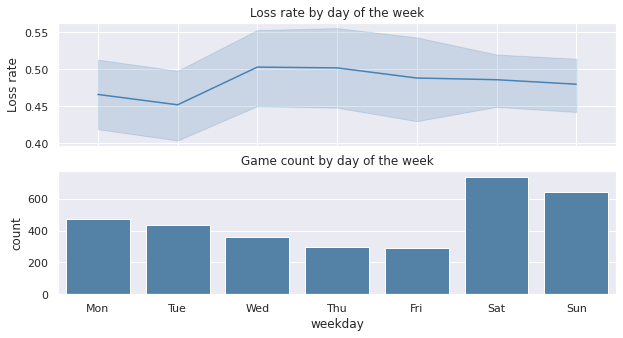

Chi2 test p value for freqs weekday and is_loss: 0.78


In [6]:
X = 'weekday'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

sns.lineplot(data=df, x=X, y=df[y], color=default_color, ax=axs[0])
sns.countplot(data=df, x=X, color=default_color, ax=axs[1])
axs[0].set_title(f"Loss rate by day of the week")
axs[1].set_title(f"Game count by day of the week")
axs[0].set_ylabel(f"Loss rate")
axs[1].set_xticklabels([weekday_mapper[int(float(l.get_text()))] for l in axs[1].get_xticklabels()])
axs[1].xaxis.set_ticks(np.arange(0,7,1))
plt.show()

# Print chi2 test p value
chi2(df, X, y)

No clear trend by weekday.

##### Hour of the day

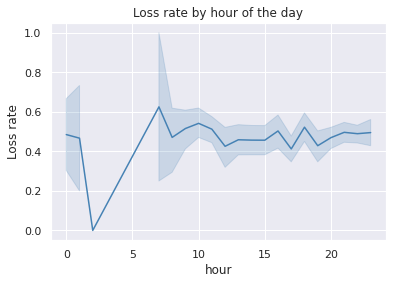

Chi2 test p value for freqs hour and is_loss: 0.644


In [7]:
X = 'hour'

sns.lineplot(data=df, x=X, y=df[y], color=default_color)
plt.title(f"Loss rate by hour of the day")
plt.ylabel(f"Loss rate")
plt.show()

# Print chi2 test p value
chi2(df, X, y)

It looks like maybe the rate of losses by time goes up later in the day.

There's no apparent correlation between loss rate and hour of the day.

##### Color (is_white)

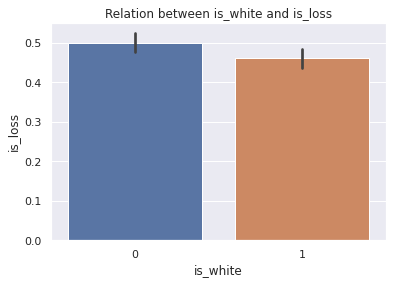

Chi2 test p value for freqs is_white and is_loss: 0.025


In [8]:
X = 'is_white'
ax = sns.barplot(data=df, x=X, y=y)
plt.title(f"Relation between {X} and {y}")
plt.show()

# Print chi2 test p value
chi2(df, X, y)

Losing is more less likely when playing white.

##### ECO code

Since ECO a game's ECO isn't known before the game begins it won't be used as a feature here.

##### Gripklo's rating

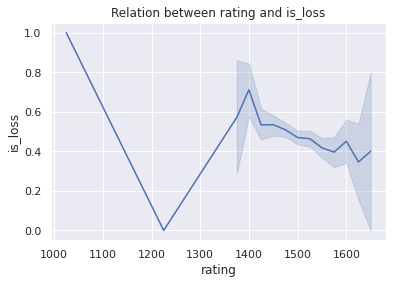

In [9]:
X = 'rating'

# Bin rating
bin_size = 25

sns.lineplot(data=df, x=df[X].div(bin_size).round().mul(bin_size), y=df[y])
plt.title(f"Relation between {X} and {y}")
plt.show()

Surprisingly the loss rate is higher when lower rated, even though that implies lower rated opposition.

##### Opponent rating

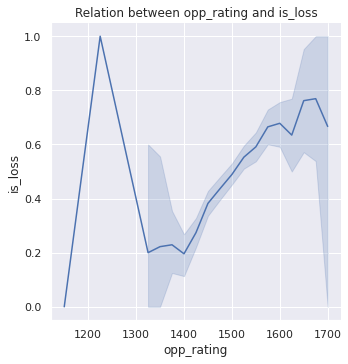

In [82]:
X = 'opp_rating'

ax = sns.relplot(x=df[X].div(bin_size).round().mul(bin_size), y=df[y], kind='line')
plt.title(f"Relation between {X} and {y}")
plt.show()

As the general loss rate goes up against stronger opposition so does the losses by time.

##### Rating difference


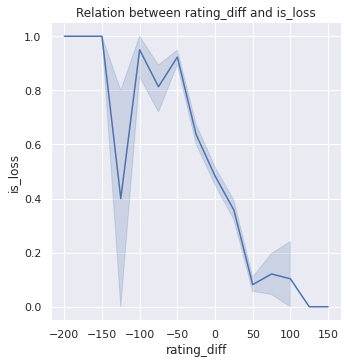

In [84]:
X = 'rating_diff'

# Bin rating
bins = df[X].div(bin_size).round().mul(bin_size)
ax = sns.relplot(x=bins, y=df[y], kind='line')
plt.title(f"Relation between {X} and {y}")
plt.show()

Losing is more common against opposition where I was the lower rated player. In both rating_diff and opp_rating it looks like the relationship may be s-shaped.

##### Time control - 3 or 5 minute game

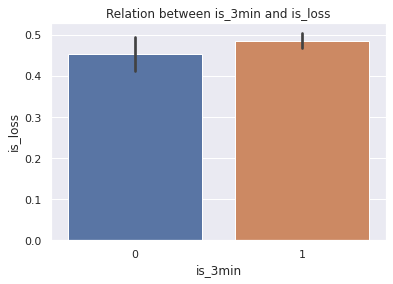

Chi2 test p value for freqs is_3min and is_loss: 0.219


In [10]:
X = 'is_3min'
ax = sns.barplot(data=df, x=X, y=y)
plt.title(f"Relation between {X} and {y}")
plt.show()

# Print chi2 test p value
chi2(df, X, y)

The p-value says this difference may well be just noise, but it'd make sense if there was a difference in the loss rate depending on time control. Let's keep this one.

##### Points won in the previous game

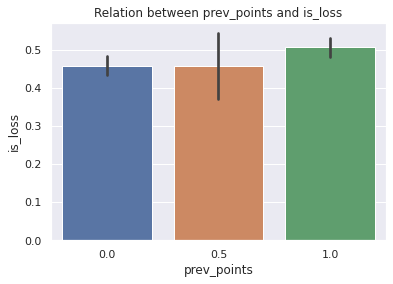

In [11]:
X = 'prev_points'
ax = sns.barplot(data=df, x=X, y=y)
plt.title(f"Relation between {X} and {y}")
plt.show()

Drawing is unusual so this one might be better defined as a dummy.

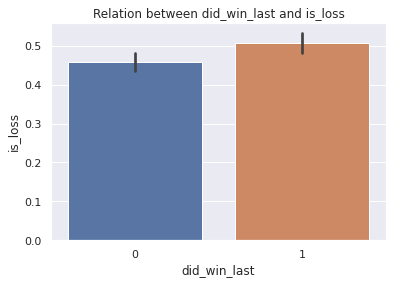

Chi2 test p value for freqs did_win_last and is_loss: 0.006


In [12]:
df['did_win_last'] = (df['prev_points'] == 1).astype('int')

X = 'did_win_last'
ax = sns.barplot(data=df, x=X, y=y)
plt.title(f"Relation between {X} and {y}")
plt.show()

# Print chi2 test p value
chi2(df, X, y)

Winning the previos game makes a loss e more likely. Winning a game will generally lead to stronger opposition so maybe that's what this is.

##### Average points taken in last X games

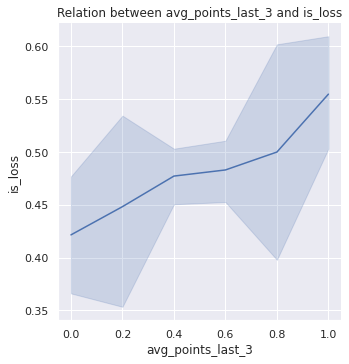

Chi2 test p value for freqs avg_points_last_3 and is_loss: 0.047


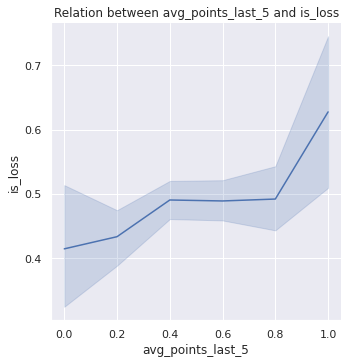

Chi2 test p value for freqs avg_points_last_5 and is_loss: 0.017


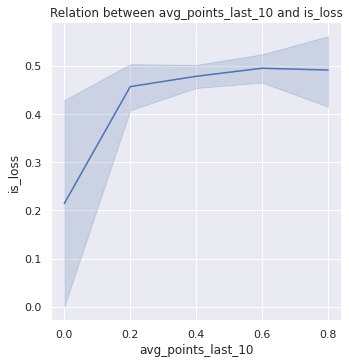

Chi2 test p value for freqs avg_points_last_10 and is_loss: 0.207


In [13]:
# Bin rating
bin_size = 0.2

X = 'avg_points_last_3'
bins = df[X].div(bin_size).round().mul(bin_size)
ax = sns.relplot(x=bins, y=df[y], kind='line')
plt.title(f"Relation between {X} and {y}")
plt.show()
# Print chi2 test p value
chi2(df, X, y)

X = 'avg_points_last_5'
bins = df[X].div(bin_size).round().mul(bin_size)
ax = sns.relplot(x=bins, y=df[y], kind='line')
plt.title(f"Relation between {X} and {y}")
plt.show()
# Print chi2 test p value
chi2(df, X, y)


X = 'avg_points_last_10'
# Bin rating
bins = df[X].div(bin_size).round().mul(bin_size)
ax = sns.relplot(x=bins, y=df[y], kind='line')
plt.title(f"Relation between {X} and {y}")
plt.show()
# Print chi2 test p value
chi2(df, X, y)

There's a positive slope in all three plots. The strongest relation is found in avg_points_last_5 so let's keep that one.

##### Number of recent games

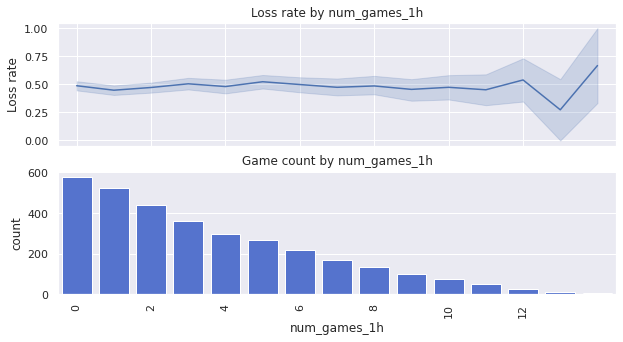

Chi2 test p value for freqs num_games_1h and is_loss: 0.825



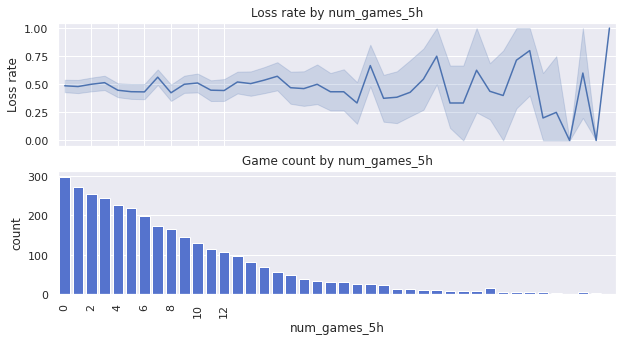

Chi2 test p value for freqs num_games_5h and is_loss: 0.302



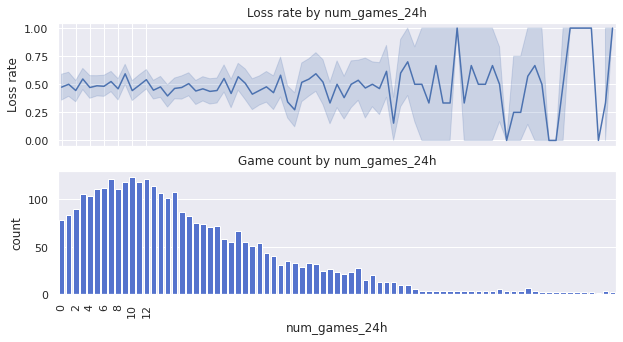

Chi2 test p value for freqs num_games_24h and is_loss: 0.585



In [14]:
for X in ['num_games_1h', 'num_games_5h', 'num_games_24h']:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

    sns.lineplot(data=df, x=X, y=df[y], ax=axs[0])
    sns.countplot(data=df, x=X, color='royalblue', ax=axs[1])
    axs[0].set_title(f"Loss rate by {X}")
    axs[1].set_title(f"Game count by {X}")
    axs[0].set_ylabel("Loss rate")
    axs[1].set_xticklabels([int(float(l.get_text())) for l in axs[1].get_xticklabels()], rotation=90)
    axs[1].xaxis.set_ticks(np.arange(0,13,2))
    plt.show()

    # Print chi2 test p value
    chi2(df, X, y)
    print("")

No apparent correlation here.

##### Rematch

'Value counts for is_rematch'

0    3129
1     114
Name: is_rematch, dtype: int64

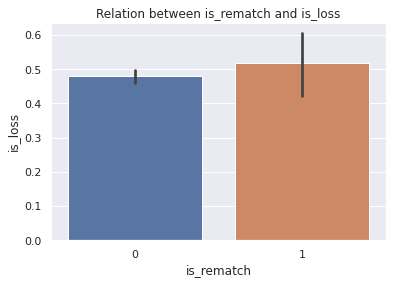

Chi2 test p value for freqs is_rematch and is_loss: 0.48


In [15]:
X = 'is_rematch'
display(f"Value counts for {X}", df[X].value_counts())

ax = sns.barplot(data=df, x=X, y=y)
plt.title(f"Relation between {X} and {y}")
plt.show()

# Print chi2 test p value
chi2(df, X, y)

Rematches are rare in this data so even if the difference seen here should stand with a larger sample size the benefit of including this feature would likely be marginal.

### Selected features  
Given the results above I'll go with the following as an initial selection of feature.
* is_white  
* rating
* opp_rating  
* rating_diff  
* is_3min  
* did_win_last  
* avg_points_last_5  

I expect some of them to be strongly correlated though. Let's take a look at the inter-feature relationships. 

In [16]:
features = [
    'is_white',
    'rating',
    'opp_rating',
    'rating_diff',
    'is_3min',
    'did_win_last',
    'avg_points_last_5']

Let's take a look at a feature correlation matrix

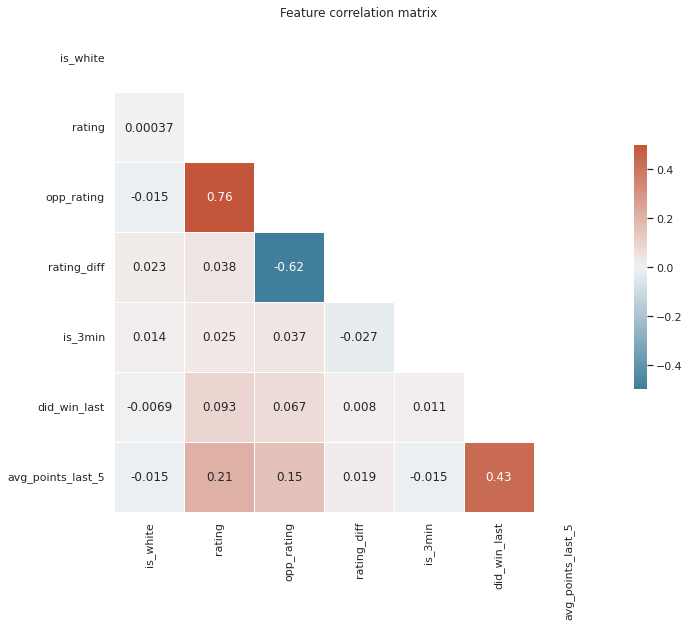

In [17]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.5, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Feature correlation matrix")
plt.show()

The features opp_rating stand out as it's strongly correlated with the difference between the player's ratings. I'll keep it as basic as possible in this first iteration and just drop it.

### Conclusion  
After this feature exploration I'm left with 6 features, 3 of them being dummy variables:

* is_white  
* rating  
* rating_diff  
* is_3min  
* did_win_last 
* avg_points_last_5  